In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

df = pd.read_csv('EF63E8-UTEM_CIER_DAVID-15MIN.csv')

df.replace('No CT', 0, inplace=True)

# Guardar los cambios en el mismo archivo
df.to_csv('EF63E8-UTEM_CIER_DAVID-15MIN.csv', index=False)
df = pd.read_csv('EF63E8-UTEM_CIER_DAVID-15MIN.csv')
lista = []

for i in (df):
    lista.append(i)
print(df.columns)

print(" ")
print("Lista ", lista )


Index(['Consumo_T', 'UTEM CIER DAVID-Mains_A (kWatts)',
       'UTEM CIER DAVID-Mains_B (kWatts)', 'UTEM CIER DAVID-Mains_C (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 1 (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 2 (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC Aula Magna  (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC Aula Magna (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L1 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L2 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L3 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L1 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L2 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L3 (kWatts)',
       'UTEM CIER DAVID-Solar_Generation-Inversor (kWatts)',
       'UTEM CIER DAVID-Room_Multi-use Circuit-Contactos David (kWatts)',
       'UTEM CIER DAVID-Lights-Alumbrado (kWatts)',
       'UTEM CIE

CREACIÓN DE MODELOS A PARTIR DEL DATAFRAME (CSV),
SE UTILIZA LA MISMA METODOLOGÍA DEL RANDOM FOREST QUE SE MUETRA ACONTINUACIÓN,  SE NOS GENERA UN ARCHIVO PARA ANALIZAR LOS RESULTADOS

0       0.78
1       0.78
2       0.80
3       0.80
4       0.79
        ... 
2492    0.56
2493    0.56
2494    0.56
2495    0.56
2496    0.56
Name: Consumo_T, Length: 2497, dtype: float64
0       0.2268
1       0.2270
2       0.2277
3       0.2275
4       0.2273
         ...  
2492    0.2056
2493    0.2065
2494    0.2067
2495    0.2061
2496    0.2060
Name: UTEM CIER DAVID-Mains_A (kWatts), Length: 2497, dtype: float64
0       0.0000
1       0.0057
2       0.0057
3       0.0057
4       0.0056
         ...  
2492    0.0226
2493    0.0226
2494    0.0227
2495    0.0227
2496    0.0227
Name: UTEM CIER DAVID-Mains_B (kWatts), Length: 2497, dtype: float64
0       0.0259
1       0.0259
2       0.0259
3       0.0259
4       0.0258
         ...  
2492    0.0252
2493    0.0254
2494    0.0253
2495    0.0254
2496    0.0254
Name: UTEM CIER DAVID-Mains_C (kWatts), Length: 2497, dtype: float64
0       0.0171
1       0.0171
2       0.0171
3       0.0171
4       0.0170
         ...  
2492    0.0168
2493

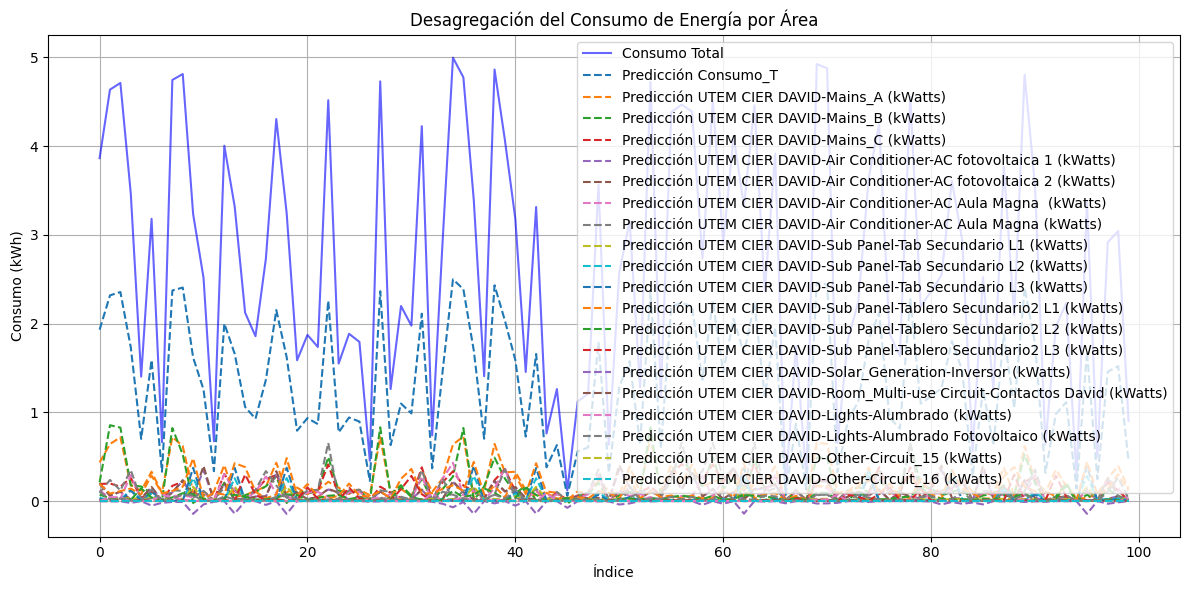

In [ ]:




# Preparar los datos para el modelo
#ANTES AQUI ESTABA EL areas
X = df[['Consumo_T']]  # Consumo total como entrada

# Crear y entrenar un modelo para cada área
modeloss = {}
for area in lista:
    y = df[area]

   
    
    print(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el modelo para esta área
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)
    
    # Guardar el modelo entrenado
    joblib.dump(modelo, f'modelo_{area.strip()}.pkl')
    
    # Almacenar el modelo en el diccionario
    modeloss[area] = modelo

# 2. Desagregar consumo de nuevos datos
def desagregar_consumo(nuevos_datos):
    # Crear un diccionario para almacenar las predicciones ajustadas
    predicciones_ajustadas = {}

    for area in lista:
        # Cargar el modelo entrenado para el área
        modelo = joblib.load(f'modelo_{area.strip()}.pkl')

        # Realizar predicciones utilizando el consumo total
        predicciones = modelo.predict(nuevos_datos[['Consumo_T']])
        predicciones_ajustadas[area] = predicciones
    
    # Convertir las predicciones ajustadas en un DataFrame
    predicciones_df = pd.DataFrame(predicciones_ajustadas)

    # Ajustar las predicciones para que sumen a 'Consumo_Total'
    predictions_total = predicciones_df.sum(axis=1)
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)
    
    # Ajustar cada predicción según el factor de escalado
    for area in lista:
        predicciones_df[area] = predicciones_df[area] * scaling_factor

    # Agregar las predicciones ajustadas al DataFrame original
    for area in lista:
        nuevos_datos[f'Consumo_{area.strip()}_Pred'] = predicciones_df[area]

    return nuevos_datos

# Crear un nuevo DataFrame con datos generales (puedes ajustar los datos reales)
df_nuevo = pd.DataFrame({
    'Consumo_T': np.random.uniform(low=0.1, high=5, size=100)  # Sustituir por datos reales
})

# Desagregar los nuevos datos
resultados = desagregar_consumo(df_nuevo)

# Mostrar resultados
print(resultados[['Consumo_T'] + [f'Consumo_{area.strip()}_Pred' for area in lista]])

# Guardar los resultados en un nuevo archivo CSV
resultados.to_csv('resultados_desagregados_universidad.csv', index=False)

# 3. Graficar los resultados de la desagregación
plt.figure(figsize=(12, 6))
plt.plot(resultados['Consumo_T'], label='Consumo Total', color='blue', alpha=0.6)

for area in lista:
    plt.plot(resultados[f'Consumo_{area.strip()}_Pred'], label=f'Predicción {area.strip()}', linestyle='--')

plt.title('Desagregación del Consumo de Energía por Área')
plt.xlabel('Índice')
plt.ylabel('Consumo (kWh)')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
print(modeloss)

for i in modeloss:
    print(i)

print(len(modeloss))

{'Consumo_T': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Mains_A (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Mains_B (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Mains_C (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 1 (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 2 (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Air Conditioner-AC Aula Magna  (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Air Conditioner-AC Aula Magna (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Sub Panel-Tab Secundario L1 (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Sub Panel-Tab Secundario L2 (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Sub Panel-Tab Secundario L3 (kWatts)': RandomForestRegressor(random_state=42), 'UTEM CIER DAVID-Sub Panel-Ta

Index(['Consumo_T', 'UTEM CIER DAVID-Mains_A (kWatts)',
       'UTEM CIER DAVID-Mains_B (kWatts)', 'UTEM CIER DAVID-Mains_C (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 1 (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 2 (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC Aula Magna  (kWatts)',
       'UTEM CIER DAVID-Air Conditioner-AC Aula Magna (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L1 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L2 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tab Secundario L3 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L1 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L2 (kWatts)',
       'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L3 (kWatts)',
       'UTEM CIER DAVID-Solar_Generation-Inversor (kWatts)',
       'UTEM CIER DAVID-Room_Multi-use Circuit-Contactos David (kWatts)',
       'UTEM CIER DAVID-Lights-Alumbrado (kWatts)',
       'UTEM CIE

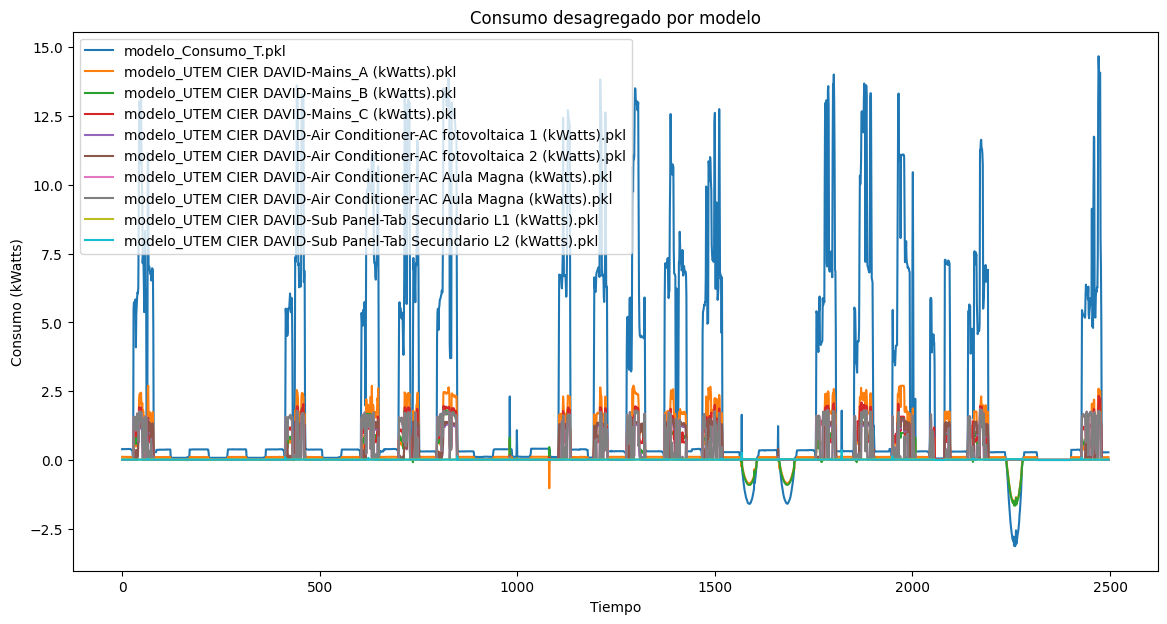

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt  # Importar matplotlib para graficar

# 1. Cargar los nuevos datos desde un archivo CSV
nuevos_datos = pd.read_csv('EF63E8-UTEM_CIER_DAVID-15MIN.csv')  # Asegúrate de que la ruta sea correcta

modelos = [
    'Consumo_T.pkl', 'UTEM CIER DAVID-Mains_A (kWatts).pkl', 'UTEM CIER DAVID-Mains_B (kWatts).pkl',
    'UTEM CIER DAVID-Mains_C (kWatts).pkl', 'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 1 (kWatts).pkl',
    'UTEM CIER DAVID-Air Conditioner-AC fotovoltaica 2 (kWatts).pkl', 'UTEM CIER DAVID-Air Conditioner-AC Aula Magna (kWatts).pkl',
    'UTEM CIER DAVID-Air Conditioner-AC Aula Magna (kWatts).pkl', 'UTEM CIER DAVID-Sub Panel-Tab Secundario L1 (kWatts).pkl',
    'UTEM CIER DAVID-Sub Panel-Tab Secundario L2 (kWatts).pkl', 'UTEM CIER DAVID-Sub Panel-Tab Secundario L3 (kWatts).pkl',
    'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L1 (kWatts).pkl', 'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L2 (kWatts).pkl',
    'UTEM CIER DAVID-Sub Panel-Tablero Secundario2 L3 (kWatts).pkl', 'UTEM CIER DAVID-Solar_Generation-Inversor (kWatts).pkl',
    'UTEM CIER DAVID-Room_Multi-use Circuit-Contactos David (kWatts).pkl', 'UTEM CIER DAVID-Lights-Alumbrado (kWatts).pkl',
    'UTEM CIER DAVID-Lights-Alumbrado Fotovoltaico (kWatts).pkl', 'UTEM CIER DAVID-Other-Circuit_15 (kWatts).pkl',
    'UTEM CIER DAVID-Other-Circuit_16 (kWatts).pkl'
]

# 2. Verificar las columnas de nuevos_datos
print(nuevos_datos.columns)

# Desagregar consumo usando la función ajustada
def desagregar_consumo(nuevos_datos):
    # Cargar modelos entrenados
    modelos_cargados = [joblib.load(f"modelo_{modelo}") for modelo in modelos]
    
    # Realizar predicciones y ajustarlas
    preds = [model.predict(nuevos_datos[['Consumo_T']]) for model in modelos_cargados]
    predictions_total = sum(preds)
    
    scaling_factor = np.where(predictions_total > nuevos_datos['Consumo_T'], 
                              nuevos_datos['Consumo_T'] / predictions_total, 1.0)
    
    # Ajustar cada predicción con el factor de escala
    preds_ajustadas = [pred * scaling_factor for pred in preds]
    
    # Agregar predicciones ajustadas al DataFrame
    for i, modelo in enumerate(modelos):
        nuevos_datos[f"modelo_{modelo}"] = preds_ajustadas[i]
    
    return nuevos_datos

# Desagregar los nuevos datos
resultados = desagregar_consumo(nuevos_datos)

# Graficar los resultados
plt.figure(figsize=(14, 7))
for i, modelo in enumerate(modelos[:10]):  # Graficar los primeros 10 modelos
    plt.plot(resultados.index, resultados[f"modelo_{modelo}"], label=f"modelo_{modelo}")

plt.xlabel("Tiempo")
plt.ylabel("Consumo (kWatts)")
plt.title("Consumo desagregado por modelo")
plt.legend(loc='best')
plt.show()


DESEGREGACIÓN APARTIR DE LOS MODELOS ENTRENAMOS, ESTOS SE CARGAN AQUÍ 
SE OBSERVA EN NEGRO EL CONSUMO TOTAL Y APARTIR DE ELLO SEPARA POR COLOR CADA DIPOSITIVO

AQUI SE OBSERVA MÁS A DETALLE EL COMPORTAMIENTO DE CADA DISPOSITIVO EN EL TRANSCURSO DEL TIEMPO

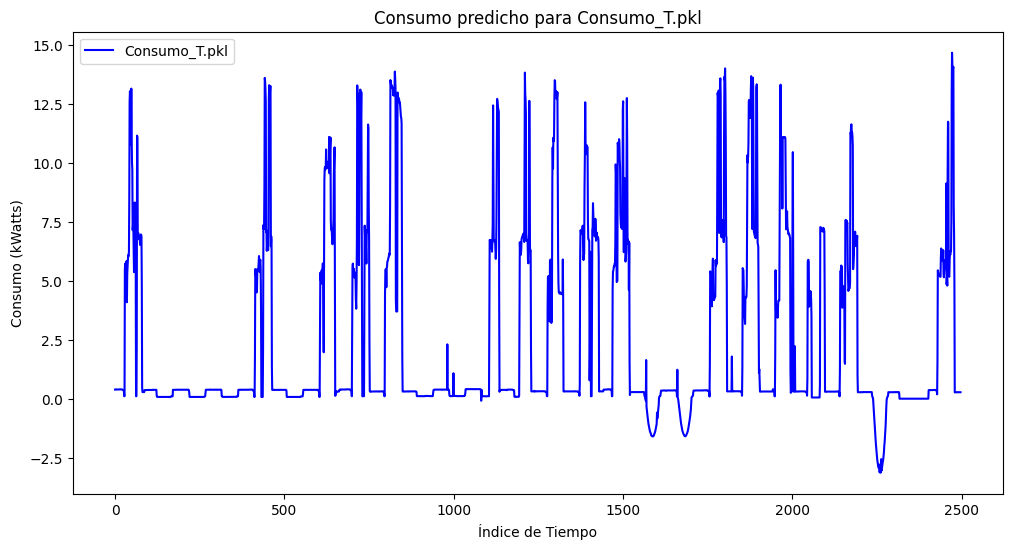

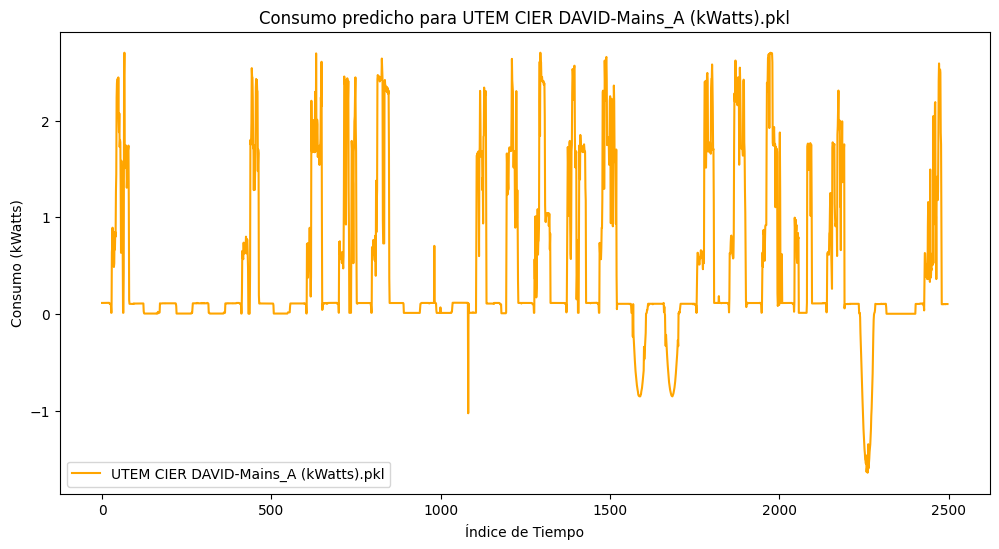

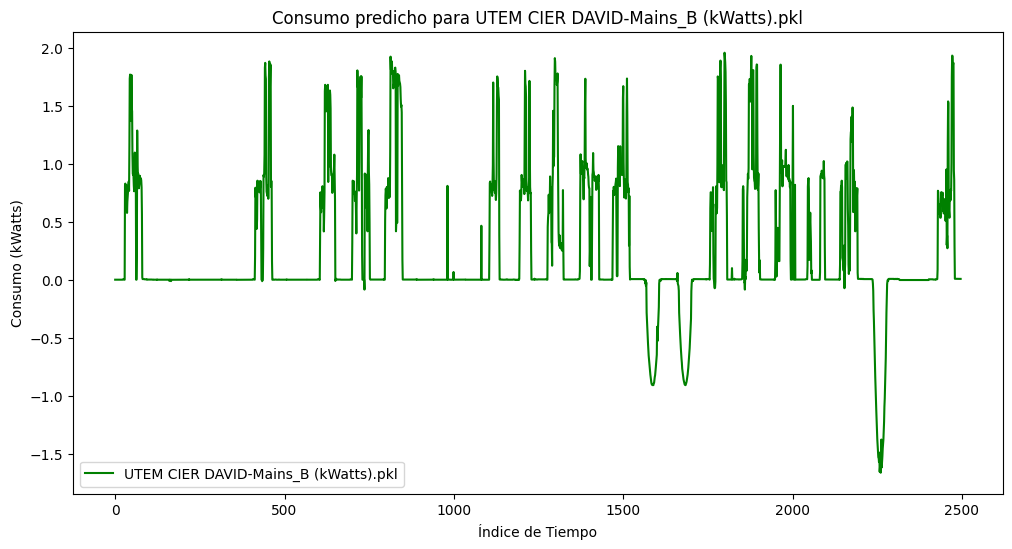

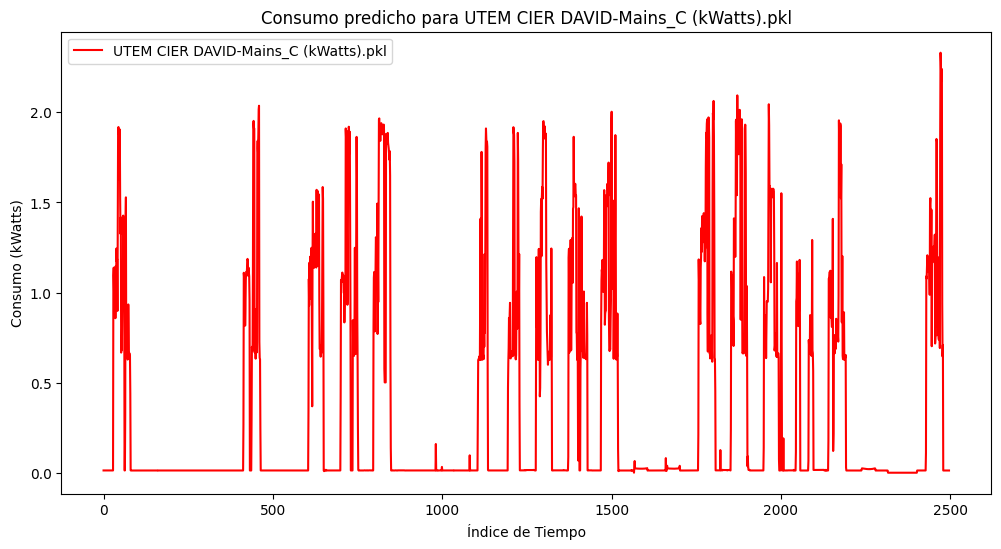

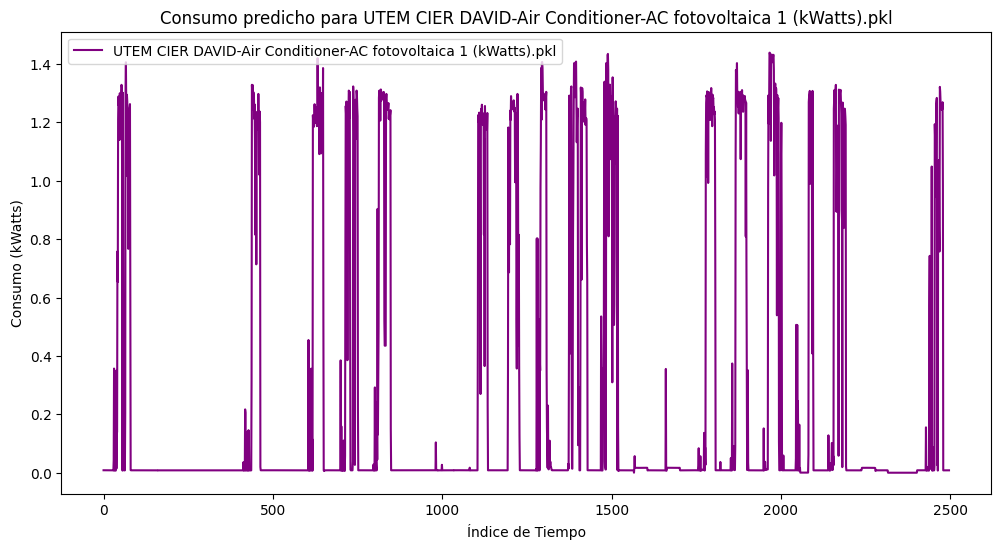

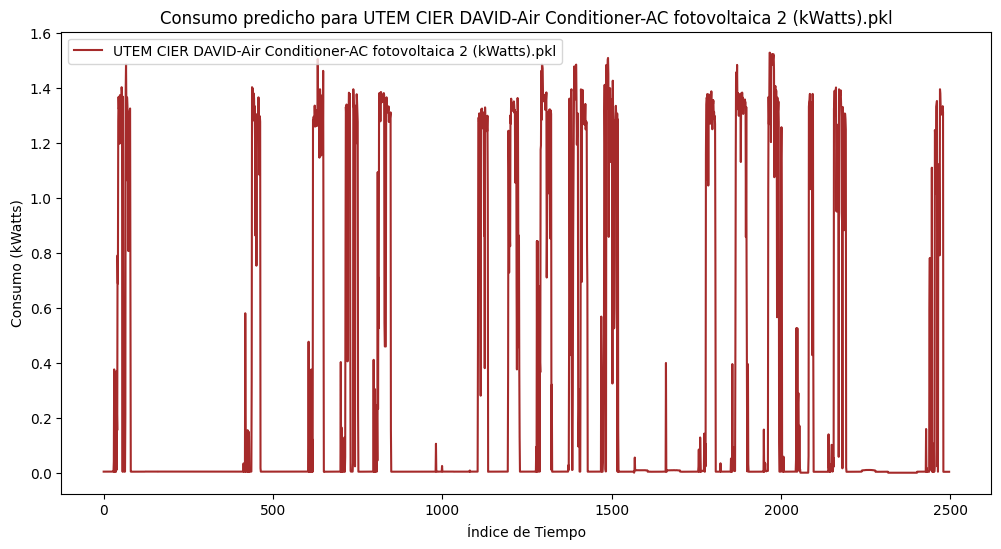

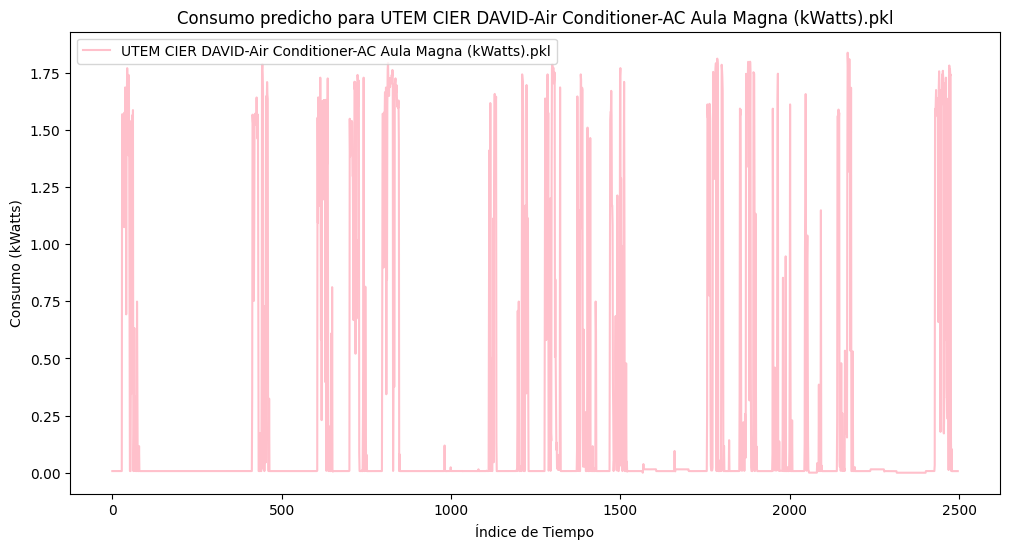

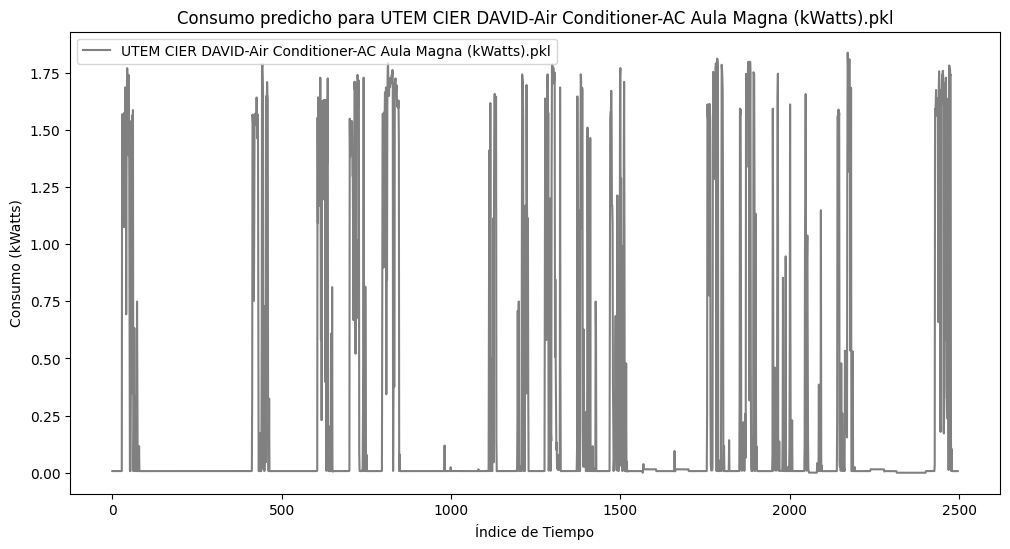

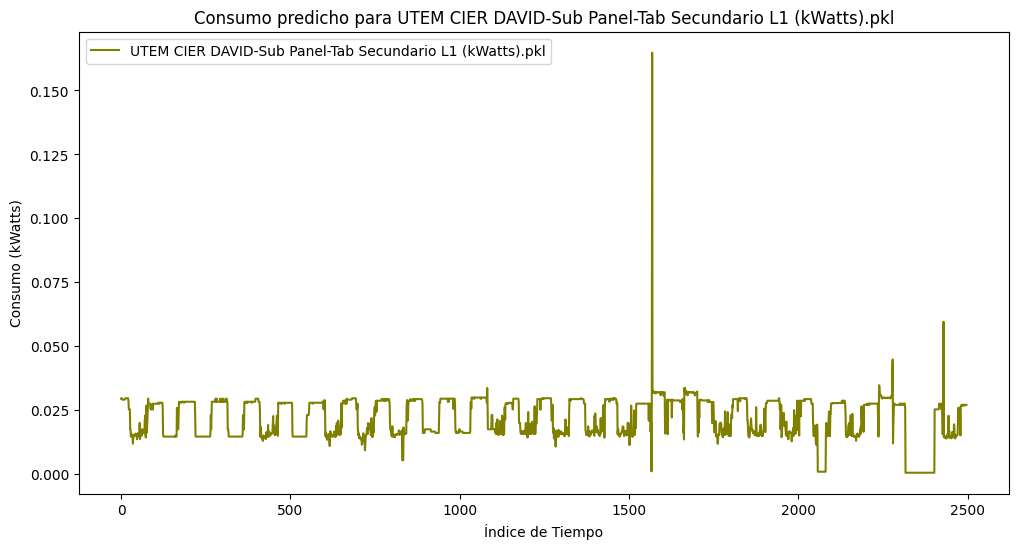

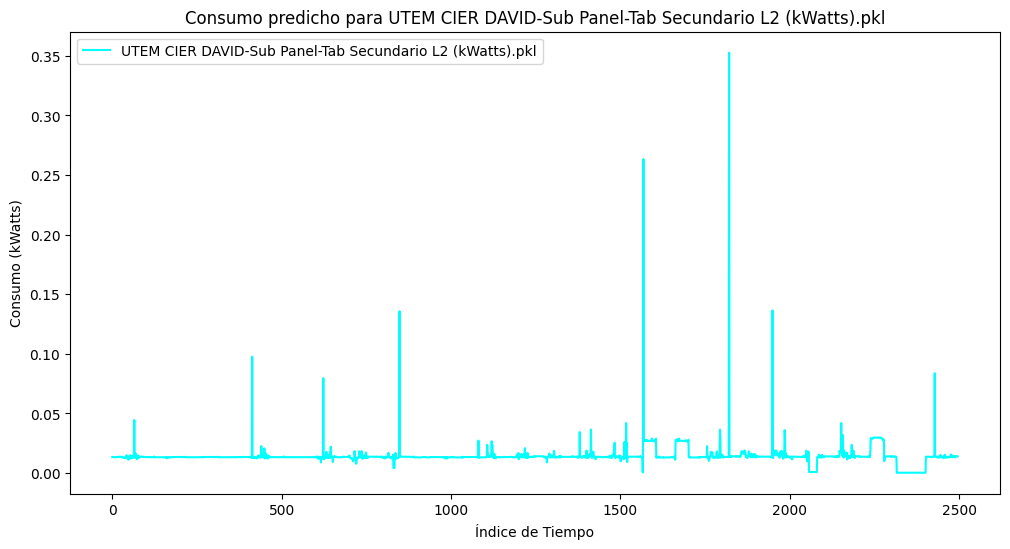

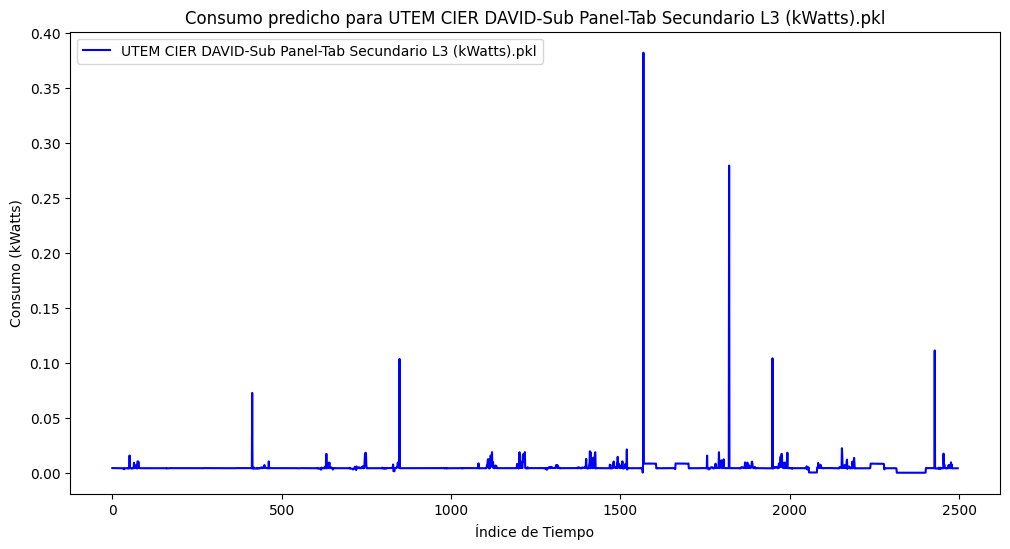

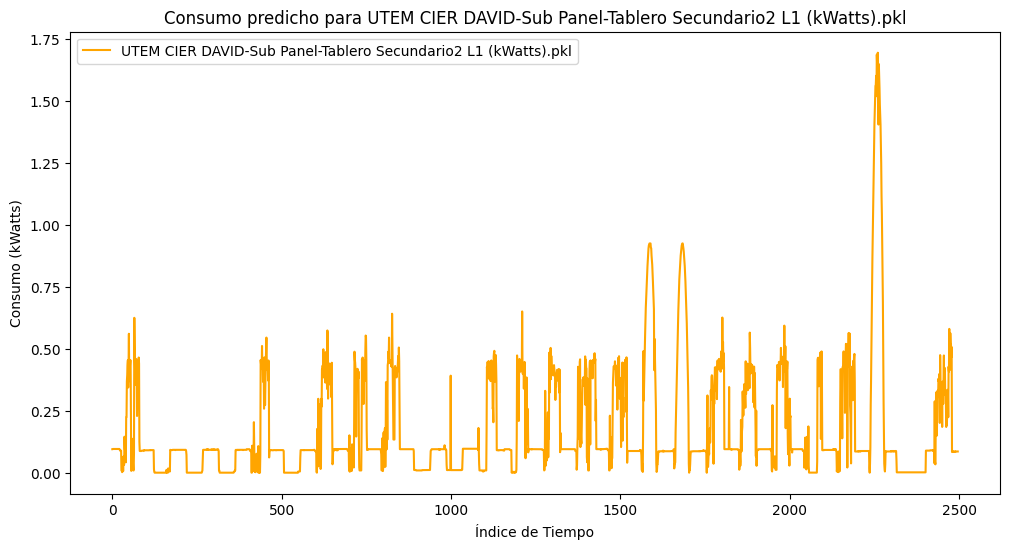

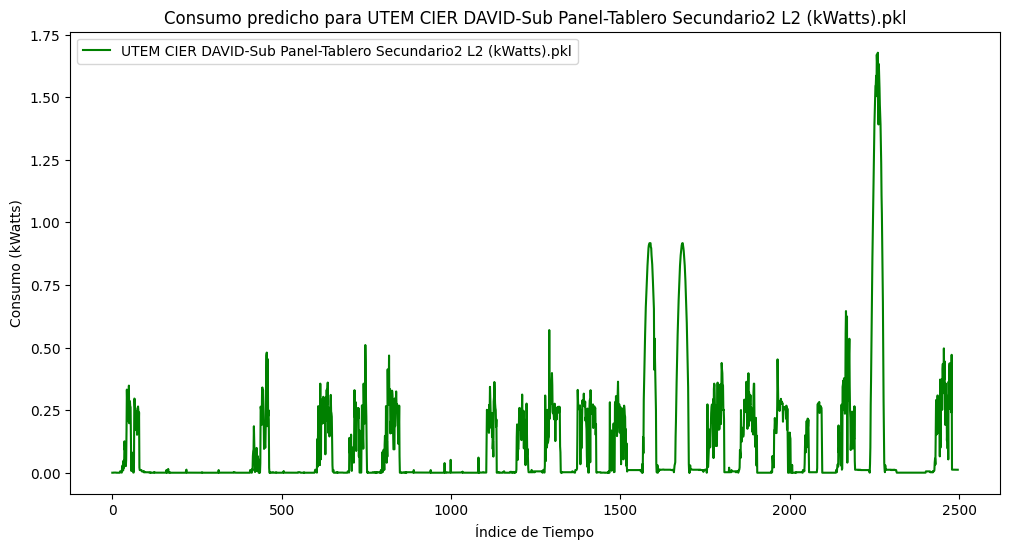

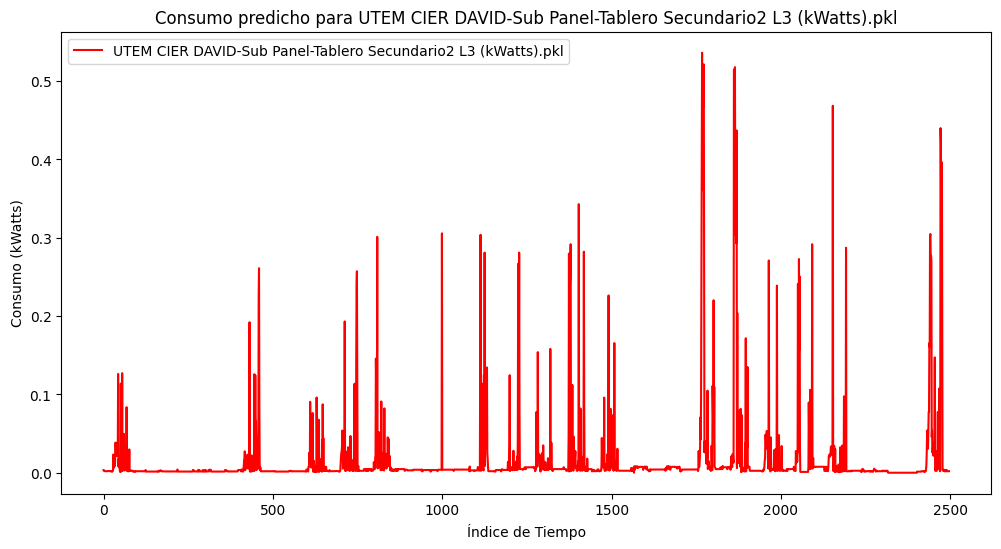

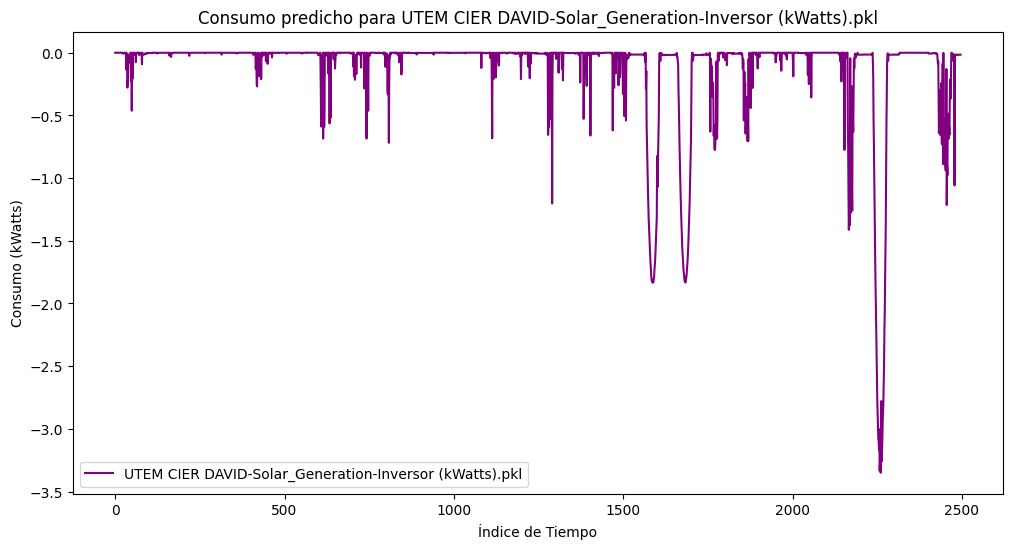

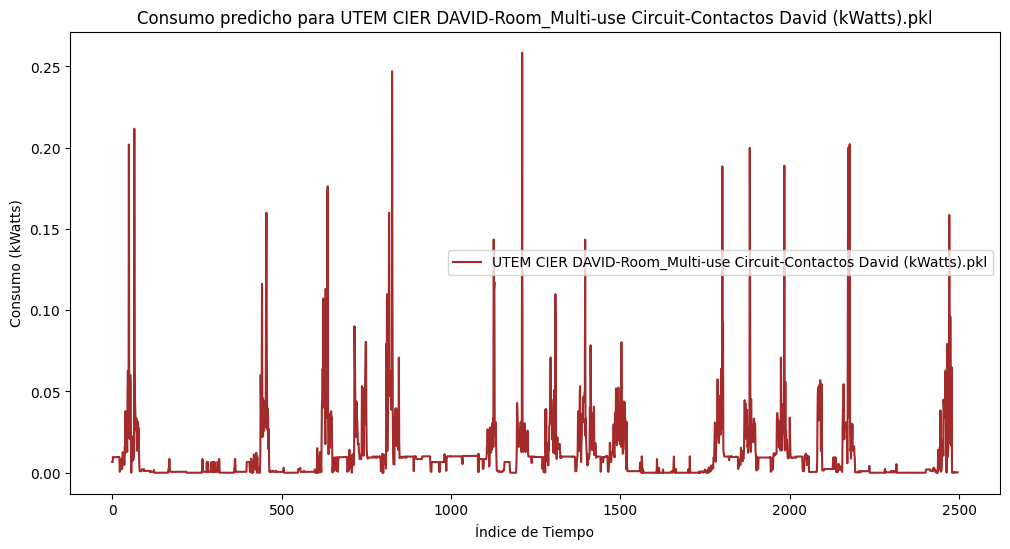

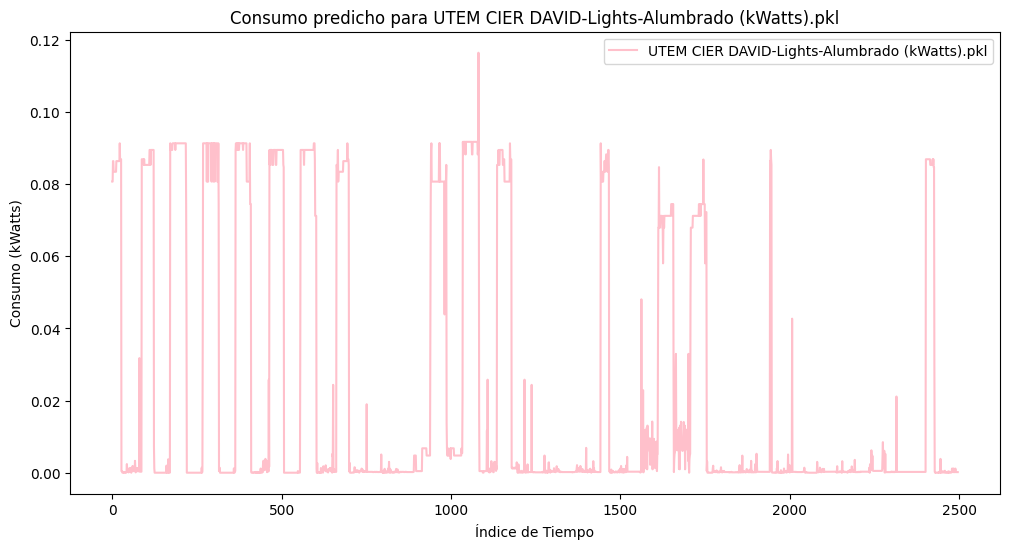

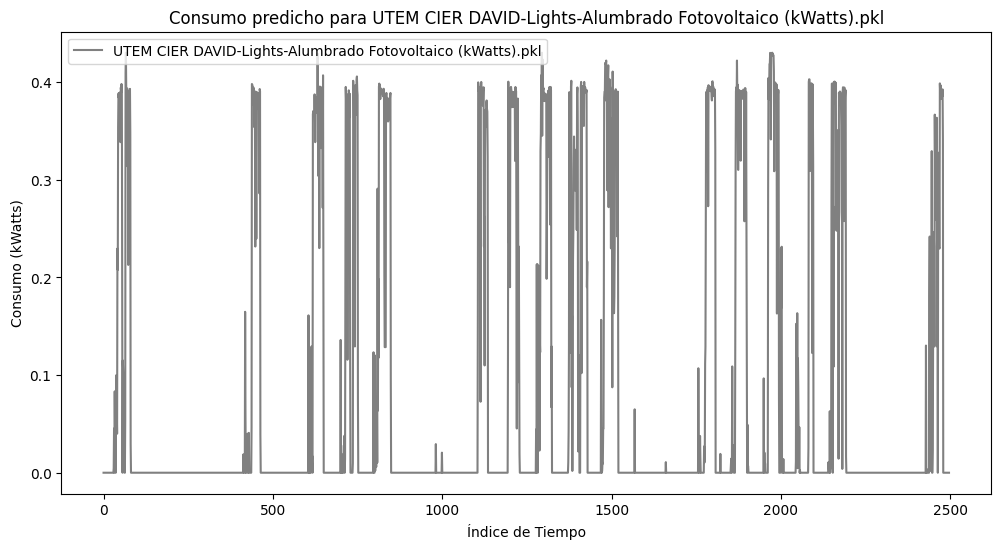

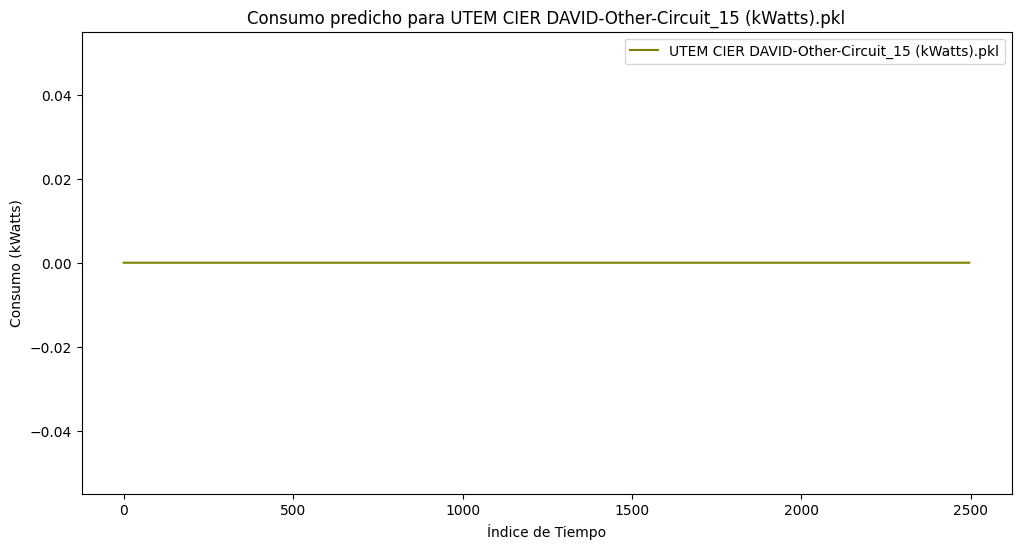

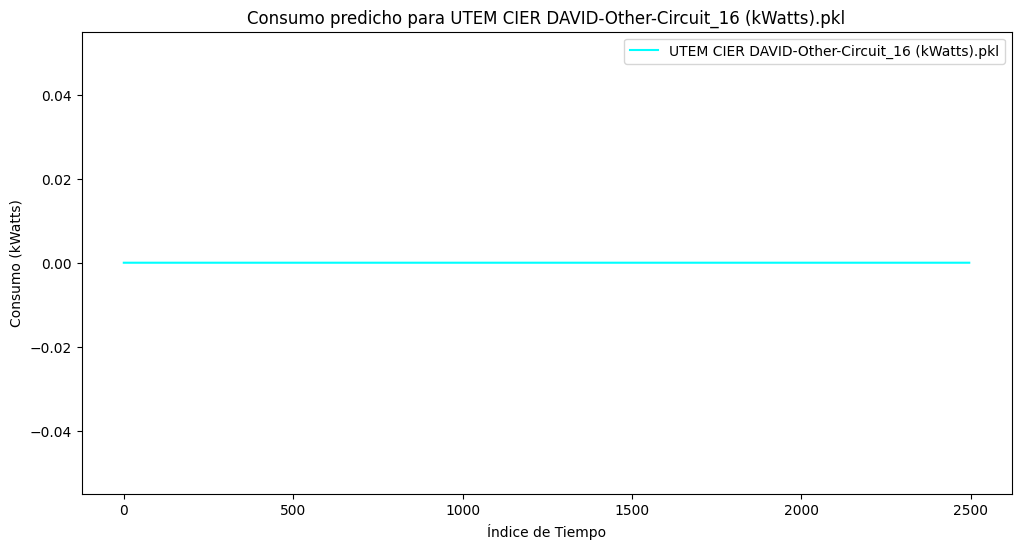

In [36]:
import matplotlib.pyplot as plt


colores = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

# GRAFICAR POR CADA DISPOSITIVO
for i, modelo in enumerate(modelos):
    plt.figure(figsize=(12, 6))
    plt.plot(resultados.index, resultados[f"modelo_{modelo}"], label=f"{modelo}", color=colores[i % len(colores)])
    plt.title(f"Consumo predicho para {modelo}")
    plt.xlabel("Índice de Tiempo")
    plt.ylabel("Consumo (kWatts)")
    plt.legend()
    plt.show()
